<a href="https://colab.research.google.com/github/leticiabbacellar/Python/blob/main/Analise_de_sentimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q translate
!pip install -q nltk
!pip install -q wordcloud
!pip install -q plotly
!pip install -q googletrans
!pip install -q deep_translator


from gspread_dataframe import set_with_dataframe
import nltk
nltk.download('stopwords')
nltk.download('rslp')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from translate import Translator
from textblob import TextBlob
from collections import Counter
from nltk.corpus import stopwords
from deep_translator import GoogleTranslator
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import string

# Baixar o dicionário do VADER para sentiment analysis
nltk.download('vader_lexicon')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv("/content/sample_data/tweet_sentiment.csv")
df.info()

for tweet in df ["tweet"].head(5):
   print (tweet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      1000 non-null   object
 1   sentiment  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB
The event starts at 5 PM.
I hate how this turned out.
Fantastic experience!
Fantastic experience!
This is the worst thing ever!


In [3]:
#traduzir textos do inglês para o português
def translate_to_portuguese(tweet):
  try:
    return GoogleTranslator (source="auto", target="portuguese").translate(tweet)
  except Exception as e:
    print(f"Erro na tradução: {e}")
    return ''

df["tweet_pt"]= df["tweet"].apply(translate_to_portuguese)
df.head(5)

,tweet,sentiment,tweet_pt
0,The event starts at 5 PM.,neutral,O evento começa às 17h.
1,I hate how this turned out.,negative,Eu odeio como isso acabou.
2,Fantastic experience!,positive,Experiência fantástica!
3,Fantastic experience!,positive,Experiência fantástica!
4,This is the worst thing ever!,negative,Esta é a pior coisa de todos os tempos!


In [4]:
sia = SentimentIntensityAnalyzer()

def get_polarity_neg(tweet):
  return sia.polarity_scores(tweet)["neg"]
def get_polarity_pos(tweet):
  return sia.polarity_scores(tweet)["pos"]
def get_polarity_neu(tweet):
  return sia.polarity_scores(tweet)["neu"]
def get_polarity_geral(tweet):
  return sia.polarity_scores(tweet)["compound"]


df["polaridade negativa"]= df["tweet"].apply(get_polarity_neg)
df["polaridade positiva"]= df["tweet"].apply(get_polarity_pos)
df["polaridade neutra"]= df["tweet"].apply(get_polarity_neu)
df["polaridade geral"]= df["tweet"].apply(get_polarity_geral)
df.head(5)


,tweet,sentiment,tweet_pt,polaridade negativa,polaridade positiva,polaridade neutra,polaridade geral
0,The event starts at 5 PM.,neutral,O evento começa às 17h.,0.000,0.000,1.000,0.0000
1,I hate how this turned out.,negative,Eu odeio como isso acabou.,0.481,0.000,0.519,-0.5719
2,Fantastic experience!,positive,Experiência fantástica!,0.000,0.796,0.204,0.5983
3,Fantastic experience!,positive,Experiência fantástica!,0.000,0.796,0.204,0.5983
4,This is the worst thing ever!,negative,Esta é a pior coisa de todos os tempos!,0.468,0.000,0.532,-0.6588


In [5]:
df= df.drop(columns= ["sentiment"])
df.head(5)

,tweet,tweet_pt,polaridade negativa,polaridade positiva,polaridade neutra,polaridade geral
0,The event starts at 5 PM.,O evento começa às 17h.,0.000,0.000,1.000,0.0000
1,I hate how this turned out.,Eu odeio como isso acabou.,0.481,0.000,0.519,-0.5719
2,Fantastic experience!,Experiência fantástica!,0.000,0.796,0.204,0.5983
3,Fantastic experience!,Experiência fantástica!,0.000,0.796,0.204,0.5983
4,This is the worst thing ever!,Esta é a pior coisa de todos os tempos!,0.468,0.000,0.532,-0.6588


In [6]:
def classifica_senti(score):
  if score < 0:
    return "Negativo"
  elif score == 0:
    return "Neutro"
  else:
    return "Positivo"

df["sentimento"]= df["polaridade geral"].apply(classifica_senti)
df.head(5)


,tweet,tweet_pt,polaridade negativa,polaridade positiva,polaridade neutra,polaridade geral,sentimento
0,The event starts at 5 PM.,O evento começa às 17h.,0.000,0.000,1.000,0.0000,Neutro
1,I hate how this turned out.,Eu odeio como isso acabou.,0.481,0.000,0.519,-0.5719,Negativo
2,Fantastic experience!,Experiência fantástica!,0.000,0.796,0.204,0.5983,Positivo
3,Fantastic experience!,Experiência fantástica!,0.000,0.796,0.204,0.5983,Positivo
4,This is the worst thing ever!,Esta é a pior coisa de todos os tempos!,0.468,0.000,0.532,-0.6588,Negativo


In [7]:
contagem_sentimentos= df["sentimento"].value_counts()
fig= px.bar(
    x=contagem_sentimentos.index,
    y=contagem_sentimentos.values,
    color=contagem_sentimentos.index,
    labels = {"x":"sentimento", "y": "quantidade", "color": "cor"},
    title= "Contagem de sentimentos"
)

fig.update_layout(
    title_font= dict (size=40, family= "Arial", color= "purple"),
)

fig.show()


[('odeio', 54), ('acabou', 54), ('decepcionado', 53), ('resultados', 53), ('decisão', 51), ('tão', 51), ('terrível', 51), ('cansado', 50), ('disso', 50), ('acontecendo', 50)]


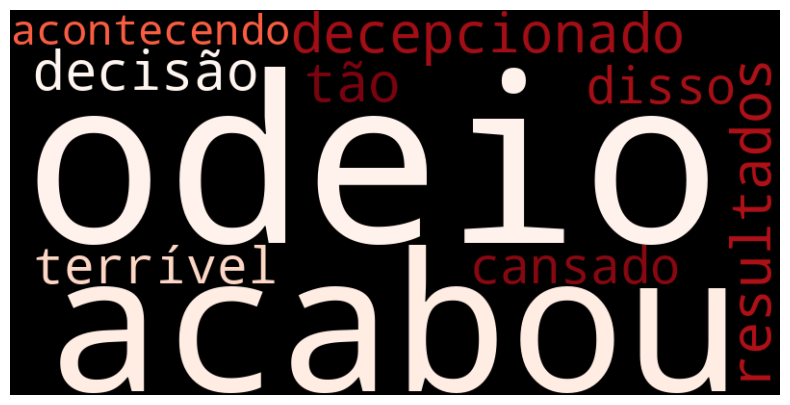

In [8]:
stopwords.words("portuguese")
stopwords_pt= set (stopwords.words("portuguese"))
tweet_negativo= df[df["sentimento"]=="Negativo"]["tweet_pt"]

def processamento (tt):
  all_tweet_pt=[]

  for tts in tt:
    words= tts.lower().translate(str.maketrans("", "", string.punctuation)).split()
    words=[word for word in words if word not in stopwords_pt]
    all_tweet_pt.extend(words)
  return Counter (all_tweet_pt).most_common(10)

top_negativos= processamento(tweet_negativo)
print(top_negativos)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="black",
    colormap="Reds"
).generate_from_frequencies(dict(top_negativos))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



[('experiência', 71), ('fantástica', 71), ('absolutamente', 69), ('amei', 69), ('tão', 67), ('feliz', 67), ('notícias', 67), ('dia', 63), ('maravilhoso', 63), ('ótimo', 60)]


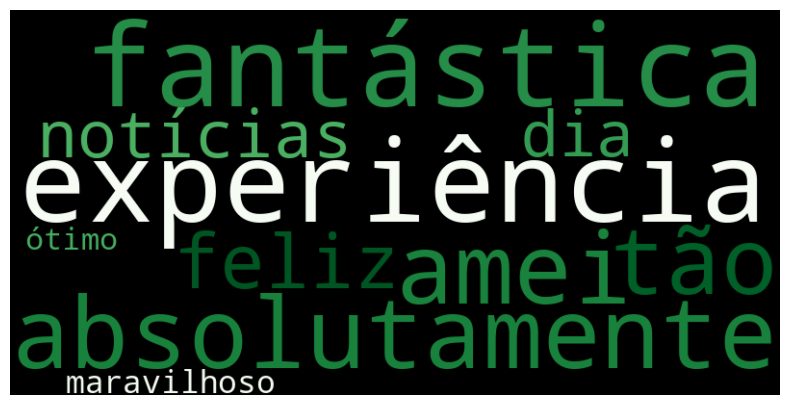

In [9]:
stopwords.words("portuguese")
stopwords_pt= set (stopwords.words("portuguese"))
tweet_positivo= df[df["sentimento"]=="Positivo"]["tweet_pt"]

def processamento (tt):
  all_tweet_pt=[]

  for tts in tt:
    words= tts.lower().translate(str.maketrans("", "", string.punctuation)).split()
    words=[word for word in words if word not in stopwords_pt]
    all_tweet_pt.extend(words)
  return Counter (all_tweet_pt).most_common(10)

top_positivo= processamento(tweet_positivo)
print(top_positivo)

wordcloud = WordCloud(
    width=800,
    height= 400,
    background_color="black",
    colormap="Greens",
).generate_from_frequencies(dict(top_positivo))

plt.figure(figsize=(10,5))
plt.imshow (wordcloud, interpolation="bilinear")
plt.axis ("off")
plt.show()

In [10]:
df= df.drop(columns= ["tweet"])
df.head(5)